In [ ]:
!pip install facenet-pytorch

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("frabbisw/facial-age")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/frabbisw/facial-age/versions/1


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE

In [ ]:
import shutil
import os

source_path = path
destination_path = "/content/facial-age"

# Move the dataset
shutil.move(source_path, destination_path)

print("Dataset moved to:", destination_path)
print("Files in new location:", os.listdir(destination_path))

Dataset moved to: /content/facial-age
Files in new location: ['face_age']


In [ ]:

base_path = '/content/facial-age/face_age/'
image_folders = os.listdir(base_path)

# print(image_folders)

age_labels = []
gender_labels = []
image_paths = []
image_names = []

for dir_name in image_folders:
    dir_path = os.path.join(base_path, dir_name)
    image_files = os.listdir(dir_path)
    for img in image_files:
        try:
            age = int(dir_name)
            age_labels.append(age)
            image_names.append(img)
            image_paths.append(os.path.join(base_path,dir_name,img))
        except Exception as e:
            # the dataset folder has another folder with the dataset itself: This will prevent that folder from joining the df
            continue


df = pd.DataFrame({
    'image_path': image_paths,
    'image_name': image_names,
    'age': age_labels
})

df

,image_path,image_name,age
0,/content/facial-age/face_age/002/8704.png,8704.png,2
1,/content/facial-age/face_age/002/5888.png,5888.png,2
2,/content/facial-age/face_age/002/2440.png,2440.png,2
3,/content/facial-age/face_age/002/1917.png,1917.png,2
4,/content/facial-age/face_age/002/2755.png,2755.png,2
...,...,...,...
9773,/content/facial-age/face_age/028/9584.png,9584.png,28
9774,/content/facial-age/face_age/028/905.png,905.png,28
9775,/content/facial-age/face_age/028/4543.png,4543.png,28
9776,/content/facial-age/face_age/028/2971.png,2971.png,28


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
mtcnn = MTCNN(image_size=224, select_largest=True, keep_all=True, device=device)

In [ ]:
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3, fill=0),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
df['Age_Group'] = pd.qcut(df['age'], q=4, labels=range(0,4))
df['Age_Interval'] = pd.qcut(df['age'], q=4)

df

,image_path,image_name,age,Age_Group,Age_Interval
0,/content/facial-age/face_age/002/8704.png,8704.png,2,0,"(0.999, 7.0]"
1,/content/facial-age/face_age/002/5888.png,5888.png,2,0,"(0.999, 7.0]"
2,/content/facial-age/face_age/002/2440.png,2440.png,2,0,"(0.999, 7.0]"
3,/content/facial-age/face_age/002/1917.png,1917.png,2,0,"(0.999, 7.0]"
4,/content/facial-age/face_age/002/2755.png,2755.png,2,0,"(0.999, 7.0]"
...,...,...,...,...,...
9773,/content/facial-age/face_age/028/9584.png,9584.png,28,2,"(25.0, 49.0]"
9774,/content/facial-age/face_age/028/905.png,905.png,28,2,"(25.0, 49.0]"
9775,/content/facial-age/face_age/028/4543.png,4543.png,28,2,"(25.0, 49.0]"
9776,/content/facial-age/face_age/028/2971.png,2971.png,28,2,"(25.0, 49.0]"


In [ ]:
from sklearn.model_selection import train_test_split

class facialAge(Dataset):
    def __init__(self, df, transform=None, preprocess=None):
        self.df = df
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = self.df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        if self.preprocess:
            image = self.preprocess(image)
        if self.transform:
            image = self.transform(image)

        return image, label



train_df, test_df = train_test_split(df, test_size=0.2, random_state=21)

train_dataset = facialAge(train_df, transform_pipeline)
test_dataset = facialAge(test_df, transform_pipeline)

train_df

,image_path,image_name,age,Age_Group,Age_Interval
6508,/content/facial-age/face_age/068/4065.png,4065.png,68,3,"(49.0, 110.0]"
5595,/content/facial-age/face_age/040/2826.png,2826.png,40,2,"(25.0, 49.0]"
6565,/content/facial-age/face_age/020/6653.png,6653.png,20,1,"(7.0, 25.0]"
279,/content/facial-age/face_age/002/9150.png,9150.png,2,0,"(0.999, 7.0]"
4218,/content/facial-age/face_age/001/6911.png,6911.png,1,0,"(0.999, 7.0]"
...,...,...,...,...,...
9336,/content/facial-age/face_age/023/6722.png,6722.png,23,1,"(7.0, 25.0]"
48,/content/facial-age/face_age/002/6519.png,6519.png,2,0,"(0.999, 7.0]"
8964,/content/facial-age/face_age/017/8043.png,8043.png,17,1,"(7.0, 25.0]"
5944,/content/facial-age/face_age/013/5911.png,5911.png,13,1,"(7.0, 25.0]"


In [ ]:
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
num_classes = 4

In [ ]:
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)
# feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 31.0MB/s]


In [ ]:
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # Total loss across all samples
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)  # Average loss per sample
    train_accuracy = 100 * correct_train / total_train

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

print("Training complete.")

Epoch [1/10], Training Loss: 1.3043, Training Accuracy: 52.25%
Epoch [2/10], Training Loss: 1.1723, Training Accuracy: 59.65%
Epoch [3/10], Training Loss: 1.0906, Training Accuracy: 60.80%
Epoch [4/10], Training Loss: 1.0361, Training Accuracy: 61.49%
Epoch [5/10], Training Loss: 0.9978, Training Accuracy: 62.17%
Epoch [6/10], Training Loss: 0.9666, Training Accuracy: 63.07%
Epoch [7/10], Training Loss: 0.9447, Training Accuracy: 63.59%
Epoch [8/10], Training Loss: 0.9260, Training Accuracy: 63.21%
Epoch [9/10], Training Loss: 0.9082, Training Accuracy: 64.00%
Epoch [10/10], Training Loss: 0.8945, Training Accuracy: 64.64%
Training complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/densenet121_weights.pth')

ValueError: mount failed

In [ ]:
model.eval()

correct_test = 0
total_test = 0

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Calculate and print the final test accuracy
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

conf_matrix = confusion_matrix(all_labels, all_predictions)

precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

print("Confusion Matrix:\n", conf_matrix)
print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_score)
print("Samples per class:", support)


Test Accuracy: 65.44%
Confusion Matrix:
 [[425  46  25  13]
 [ 65 252 116  37]
 [ 18 102 280 105]
 [ 21  37  91 323]]

Precision per class: [0.80340265 0.57665904 0.546875   0.67573222]
Recall per class: [0.83497053 0.53617021 0.55445545 0.68432203]
F1-score per class: [0.81888247 0.55567806 0.55063913 0.68      ]
Samples per class: [509 470 505 472]


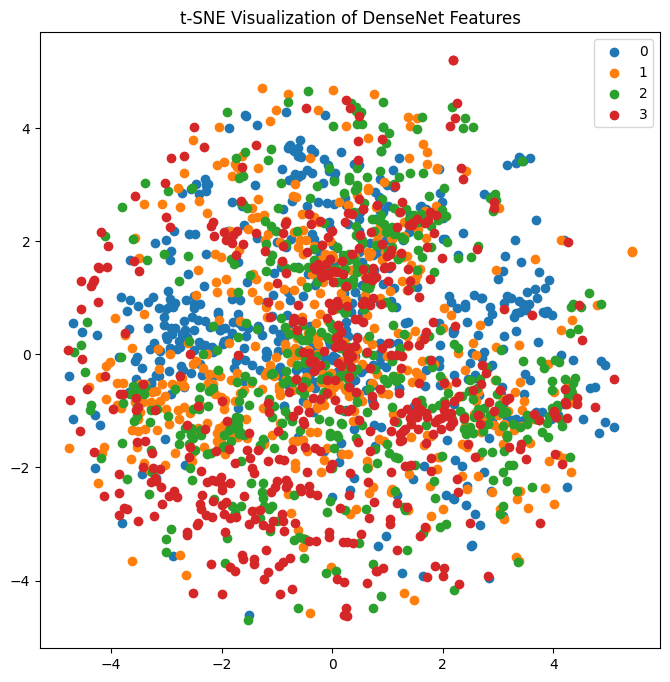

In [ ]:
features = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = feature_extractor(images)
        features.append(outputs.view(outputs.size(0), -1).cpu())
        labels.append(label.cpu())

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 8))
for label in set(labels):
    plt.scatter(
        reduced_features[labels == label, 0],
        reduced_features[labels == label, 1],
        label=str(label)
    )
plt.legend()
plt.title("t-SNE Visualization of DenseNet Features")
plt.show()